In [29]:
import pandas as pd
from plotnine import ggplot, aes, geom_boxplot, theme, element_text, labs, geom_col, ggtitle, geom_bar, facet_wrap, geom_point, geom_text, ylim, scale_y_log10
import numpy as np

In [30]:
df = pd.read_csv('avocado-updated-2020.csv')

For each date, there is the average price, the total number of avocados sold and then total numbers broken down by PLU, the total number of bags and then broken down by small, large, and xlarge bags, and then type (conventional or organic), year, and location. Most of these are numeric values, but type and location are categorical.

## Cleaning

In [32]:
#in this section, I made a csv of the unique values of geography. I then downloaded it
#by hand I put in the type of geography it was such as city, region, etc.

#df['geography'].unique()
#unique_geography_df = pd.DataFrame(df['geography'].unique(), columns=['geography'])
#unique_geography_df.to_csv('unique_geography.csv', index=False)

In [33]:
#read in the updated csv with the types of geography and add it to a column of the dataframe
types = pd.read_csv('unique_geography.csv')
df = df.merge(types, on=['geography'], how='outer')


In [34]:
#rename the PLU columns to the size it corresponds to
df = df.rename(columns = {'4046':'Small','4225':'Large','4770':'XLarge'})

# Exercises

## Problem 3

In [35]:
#filter out to only regions, organix, in 2017
regions = df[df['Gclass']=='Region']
RO = regions[regions['type']=='organic']
ROY = RO[RO['year']== 2017]

#groupby region and if they are small, and then sort from highest to lowest
ROYTotal = ROY[['Small','geography']].groupby('geography').sum()
ROYTotal = ROYTotal.sort_values(by='Small', ascending=False)
ROYTotal

,Small
geography,
West,1870206.29
South Central,1717104.19
Northeast,925832.36
Southeast,285124.34
Great Lakes,202487.68
Midsouth,186395.50
Plains,168583.40
Northern New England,1249.48


As you can see above, the West sold the most total organic, small Hass avocados in 2017.

## Problem 4

In [36]:
#split the date variable
df['date'] = pd.to_datetime(df['date'])
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day

#group by month and find the mean total volume per month, sorted highest to lowest
MonthAvg = df[['month','total_volume']].groupby('month').mean()
MonthAvg = MonthAvg.sort_values(by='total_volume',ascending=False)
MonthAvg

,total_volume
month,
5,1.123632e+06
2,1.095374e+06
6,1.051247e+06
4,1.016582e+06
3,9.957150e+05
1,9.853122e+05
7,9.832681e+05
8,9.499249e+05
9,9.064773e+05


As you can see above, May has the highest average volume of avocado sales.

## Problem 5

In [37]:
#filter to only metro region
metros = df[df['Gclass']=='Metro']

#groupby geography, and find the total of the total volumes and the mean of the total volumes for each, sorted highest to lowest
MTot = metros[['geography','total_volume']].groupby('geography').agg(total_volume_sum=('total_volume', 'sum'), total_volume_mean=('total_volume', 'mean'))
MTot = MTot.sort_values(by='total_volume_sum', ascending=False)
MTot

,total_volume_sum,total_volume_mean
geography,,
Los Angeles,9.593505e+08,1.567566e+06
New York,5.282452e+08,8.631458e+05
Dallas/Ft. Worth,4.362042e+08,7.127519e+05
Phoenix/Tucson,3.825234e+08,6.250383e+05
Baltimore/Washington,2.767646e+08,4.522298e+05
Miami/Ft. Lauderdale,2.317448e+08,3.786681e+05
Raleigh/Greensboro,1.079793e+08,1.764368e+05
Hartford/Springfield,1.046050e+08,1.709231e+05
New Orleans/Mobile,9.466657e+07,1.546839e+05


The metro areas that sold the most total avocados (also sold the most avocados on average) were LA, New York, DFW, Phoenix/Tuscon, and Baltimore/Washington.

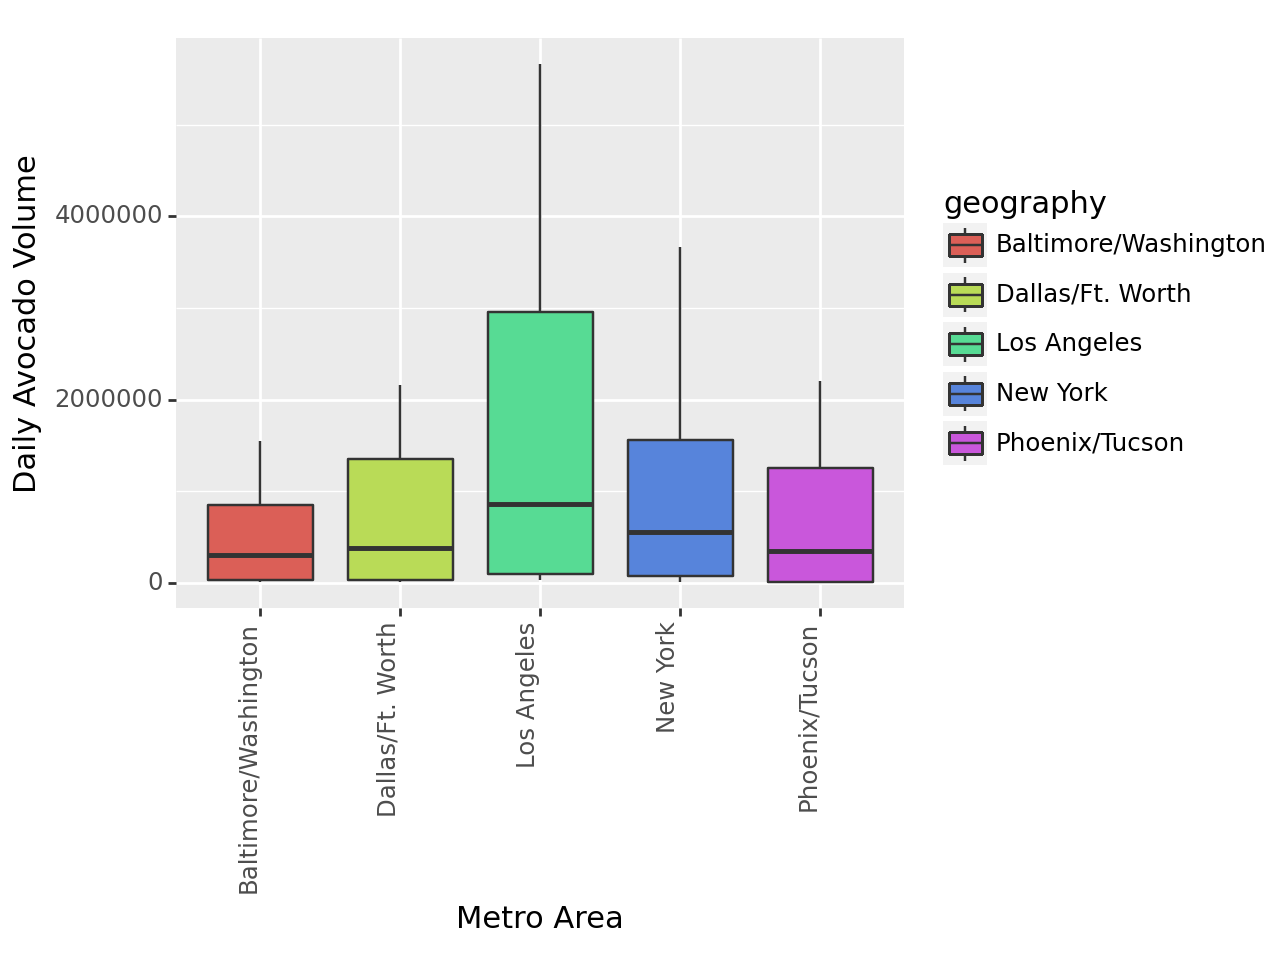

In [38]:
#create a dataframe with only the top 5 from the previous table
Top5 = df[(df['geography'] == 'Los Angeles') |
          (df['geography'] == 'New York') |
          (df['geography'] == 'Dallas/Ft. Worth') |
          (df['geography'] == 'Phoenix/Tucson') |
          (df['geography'] == 'Baltimore/Washington')]

plot = (ggplot(Top5, aes(x='geography', y='total_volume', fill='geography'))
        + geom_boxplot()
        + theme(axis_text_x=element_text(rotation=90, hjust=1))
        +labs(y='Daily Avocado Volume', x='Metro Area'))

plot.draw()

citations

https://stackoverflow.com/questions/47714540/plotnine-rotating-labels



## Problem 6

In [39]:
Cali = df[(df['geography']=='Los Angeles') | (df['geography']=='San Diego') |(df['geography']=='Sacramento') |(df['geography']=='San Francisco') ]


## Problem 7

In [40]:
#create individual dataframes for organic and conventional
CaliOrg = Cali[Cali['type']=='organic']
CaliConv = Cali[Cali['type']=='conventional']

In [41]:
#merge on date and geography, but with suffixes for organic and convetional on the other values
merged = CaliOrg.merge(CaliConv, on=['date','geography'],suffixes = ('Org','Conv'), how='outer')

In [42]:
#create a column that calculates the price difference
merged['diff'] = merged['average_priceOrg']-merged['average_priceConv']

#group by geography and find the average, total, and median difference between the types for each city
summ = merged[['geography', 'diff']].groupby('geography').agg(diffAvg = ('diff','mean'), diffTot = ('diff','sum'), diffMed = ('diff','median'))
summ

,diffAvg,diffTot,diffMed
geography,,,
Los Angeles,0.527778,161.50,0.53
Sacramento,0.578497,177.02,0.54
San Diego,0.684510,209.46,0.67
San Francisco,0.718954,220.00,0.71


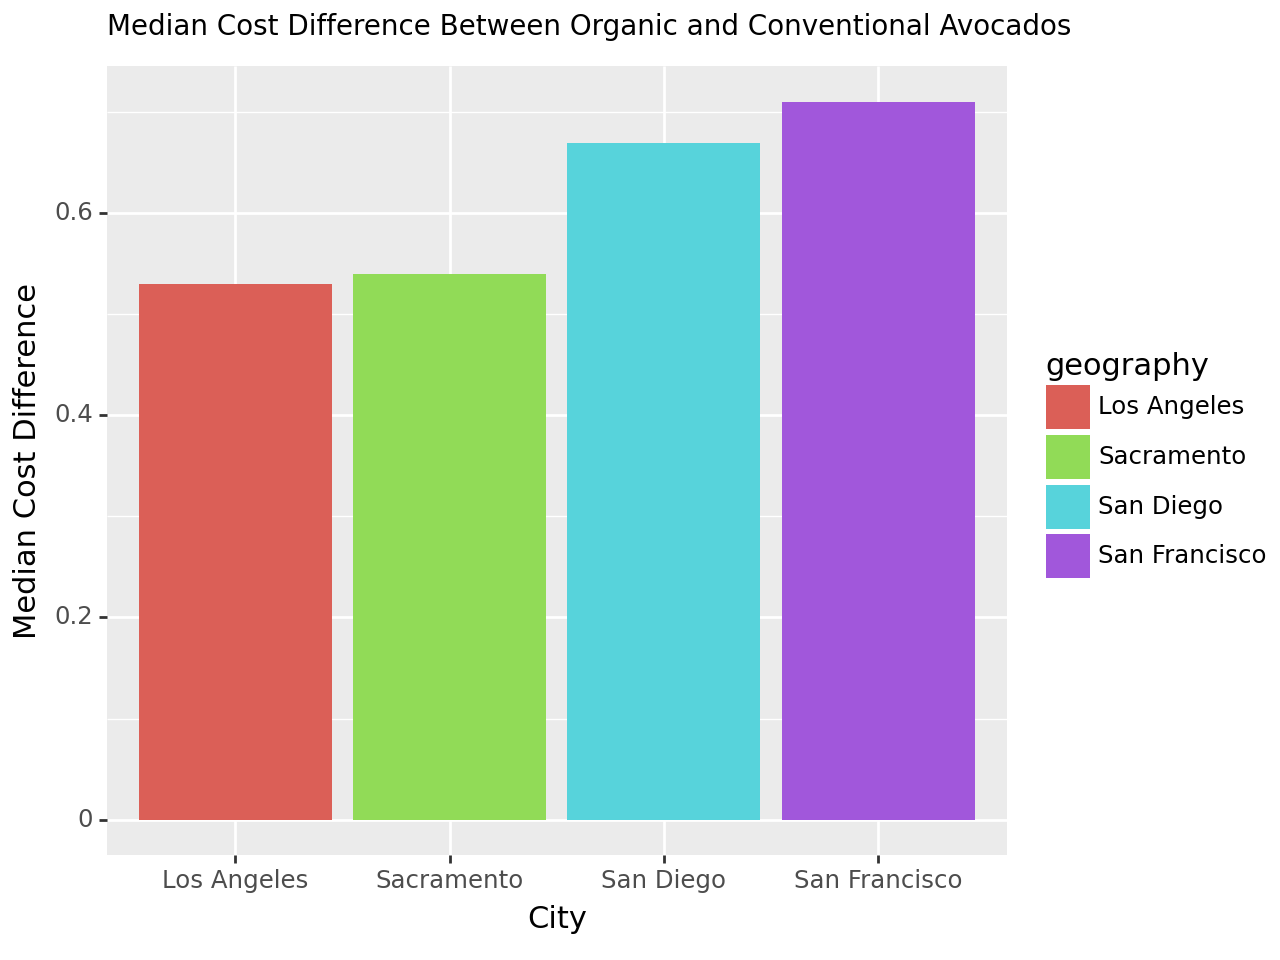

In [43]:
plot = (ggplot(summ.reset_index(), aes(x='geography', y='diffMed', fill='geography'))
    + geom_col()
    + labs(x='City', y='Median Cost Difference')
    + ggtitle('Median Cost Difference Between Organic and Conventional Avocados')
    + theme(plot_title=element_text(size=10)))
print(plot)

As you can see by the above graph and table, San Francisco has the highest median difference between prices of organic and conventional avocados (as well as highest average and total differences).

## Problem 8

In [44]:
#make a copy of the dataframe that only has what I need
work = Cali[['geography','Small','Large','XLarge','type', 'date']].copy()

#separate by type
ConvWork = work[work['type']=='conventional']
OrgWork = work[work['type']=='organic']

#drop type (so it doesn't mess with the melt)
Conv = ConvWork.drop('type', axis=1)
Org = OrgWork.drop('type',axis=1)

#melt each of them so that size is a column and the other column is the amount of each size
NewConv = Conv.melt(id_vars=['geography', 'date'], value_name = 'amount', var_name = 'size')
NewOrg = Org.melt(id_vars=['geography', 'date'], value_name = 'amount', var_name = 'size')


In [45]:
#groupby geography and size to find the total amount of each size per city
C = NewConv.groupby(['geography','size',]).agg(amount=('amount','sum')).reset_index()
O = NewOrg.groupby(['geography','size']).agg(amount=('amount','sum')).reset_index()

In [46]:
#groupby geography to find the total amount of each city
TotByCityO = O.groupby('geography').agg(total_amount=('amount', 'sum')).reset_index()
TotByCityC = C.groupby('geography').agg(total_amount=('amount', 'sum')).reset_index()

#merge with original dataframe
NewO = O.merge(TotByCityO, on='geography', how='left')
NewC = C.merge(TotByCityC, on='geography', how='left')

#calculate proportions
NewO['proportion'] = NewO['amount']/NewO['total_amount']
NewC['proportion'] = NewC['amount']/NewC['total_amount']

In [47]:
#making a copy with just what I need
NeedO = NewO[['geography','size','proportion']].copy()
NeedC = NewC[['geography','size','proportion']].copy()

#adding a type column for the merge
NeedO['type'] = 'organic'
NeedC['type'] = 'conventional'

#merging the organic and conventional tables
final = NeedO.merge(NeedC, on = ['geography','size','proportion', 'type'], how = 'outer')

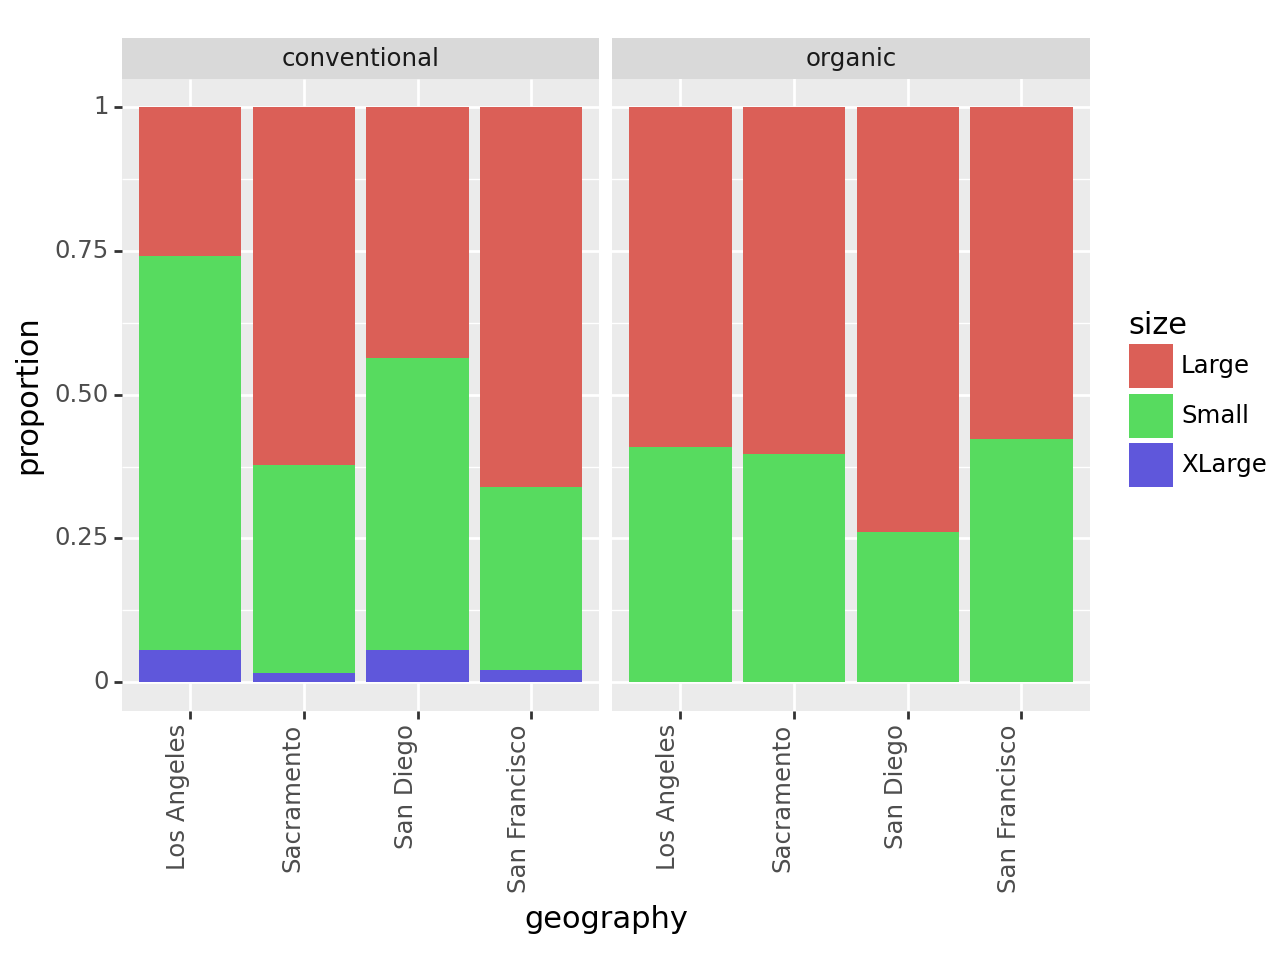

<Figure Size: (640 x 480)>

In [48]:
p = (ggplot(final, aes(x='geography',y='proportion',fill='size'))
+ geom_bar(stat='identity', position='stack')
+facet_wrap('type')
+ theme(axis_text_x=element_text(rotation=90, hjust=1)))
p

# Final Problem

Data Source: https://www.fhfa.gov/DataTools/Downloads/Pages/House-Price-Index-Datasets.aspx


The HPI is the Housing Price Index, and higher HPI corresponds to higher housing prices.

In [49]:
hpi = pd.read_csv('HPI_AT_metro.csv')

In [50]:
# Filter out the cities I need and make a copy
hpiDF = hpi[(hpi['City'] == 'Los Angeles-Long Beach-Glendale, CA  (MSAD)') |
            (hpi['City'] == 'Sacramento-Roseville-Folsom, CA') |
            (hpi['City'] == 'San Diego-Chula Vista-Carlsbad, CA') |
            (hpi['City'] == 'San Francisco-San Mateo-Redwood City, CA  (MSAD)')].copy()

# Name dictionary
city_mapping = {
    'Los Angeles-Long Beach-Glendale, CA  (MSAD)': 'Los Angeles',
    'Sacramento-Roseville-Folsom, CA': 'Sacramento',
    'San Diego-Chula Vista-Carlsbad, CA': 'San Diego',
    'San Francisco-San Mateo-Redwood City, CA  (MSAD)': 'San Francisco'
}

# Making names easier to type
hpiDF.loc[:, 'City'] = hpiDF['City'].replace(city_mapping)

# Replacing '-' values with NaN
hpiDF.loc[:, 'Index'] = hpiDF['Index'].replace('-', np.nan)

# Only keep the columns I need
Need = hpiDF[['City', 'Yr', 'Quarter', 'Index']].copy()

#convert index to float to calculate on it
Need['Index'] = Need['Index'].astype('float')

#find the average value of the HPI by city by year
housingDf = Need.groupby(['City', 'Yr']).agg(Index=('Index', 'mean')).reset_index()

In [51]:
#Cali['year'].unique()
#filter to match the years in the avocado dataframe
hdf = housingDf[(housingDf['Yr']>2014) & (housingDf['Yr']<2021)]

In [52]:
#calculate the average price per year per city of avocados
avos = Cali.groupby(['geography','year']).agg(Price=('average_price', 'mean')).reset_index()

In [53]:
#rename the columns so it's easy to merge
avos = avos.rename(columns = {'geography':'City','year':'Yr'})

In [54]:
#merge the housing and avocado datasets
AH = avos.merge(hdf, on=['City','Yr'], how='outer')

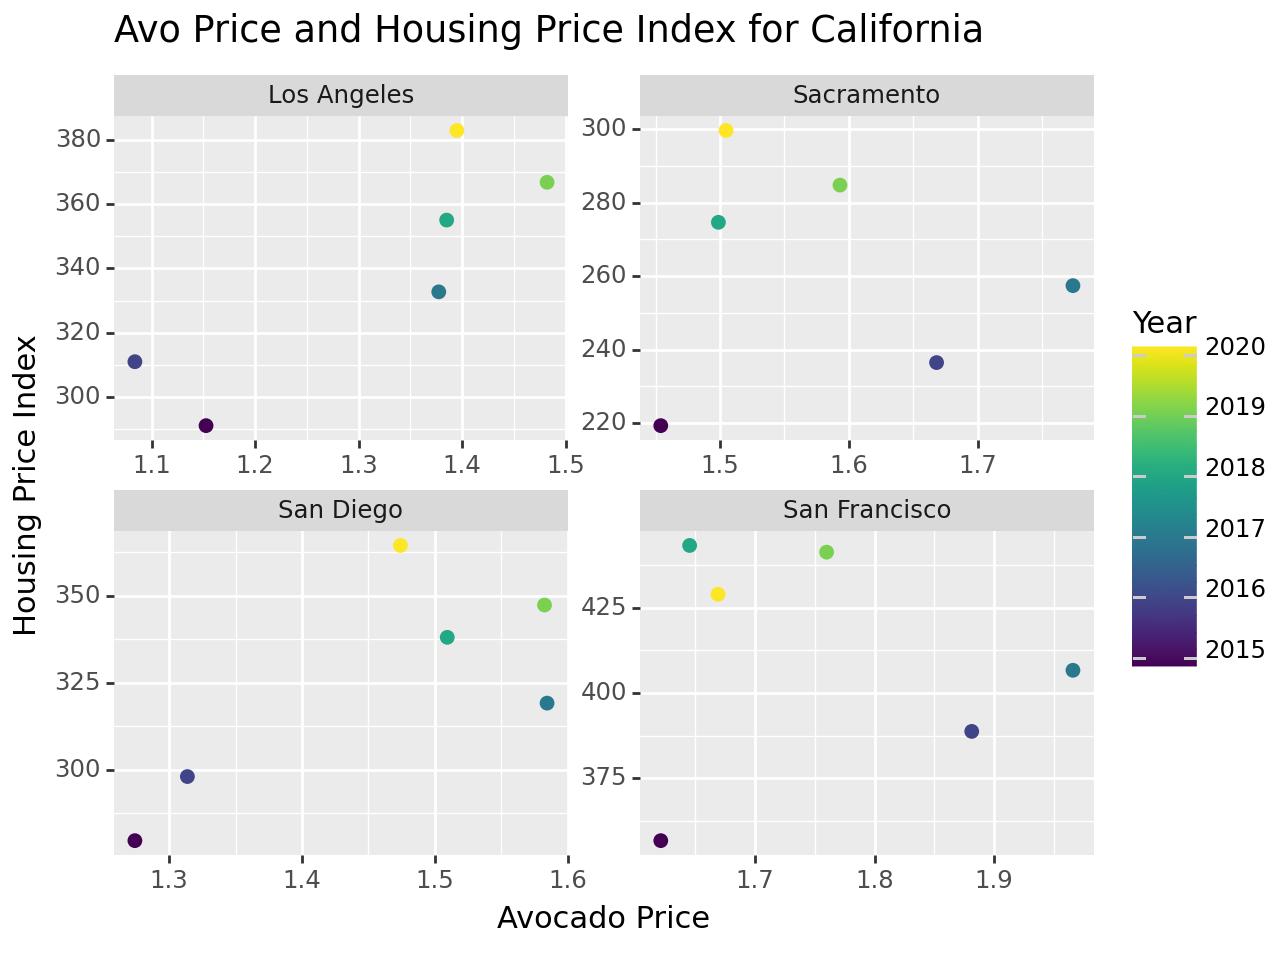

In [55]:
p = (ggplot(AH, aes(x='Price', y='Index', color='Yr'))
     + geom_point(size=2)
     #+ geom_text(aes(label='Yr'), size=8, va='bottom')
     + facet_wrap('~ City', scales='free')
     + labs(title="Avo Price and Housing Price Index for California",
            x="Avocado Price",
            y="Housing Price Index",
            color="Year")
     #+ ylim(0, 500)
)

print(p)

As one can see from the above graph, in Los Angeles and San Diego there were clear positive correlations between avocado price and the HPI between 2015 and 2020. In San Francisco and Sacramento, this happened from 2015 to 2017, but then the price of avocados dropped in 2018, and the HPI and avocado price remained around the same from 2018-2020.

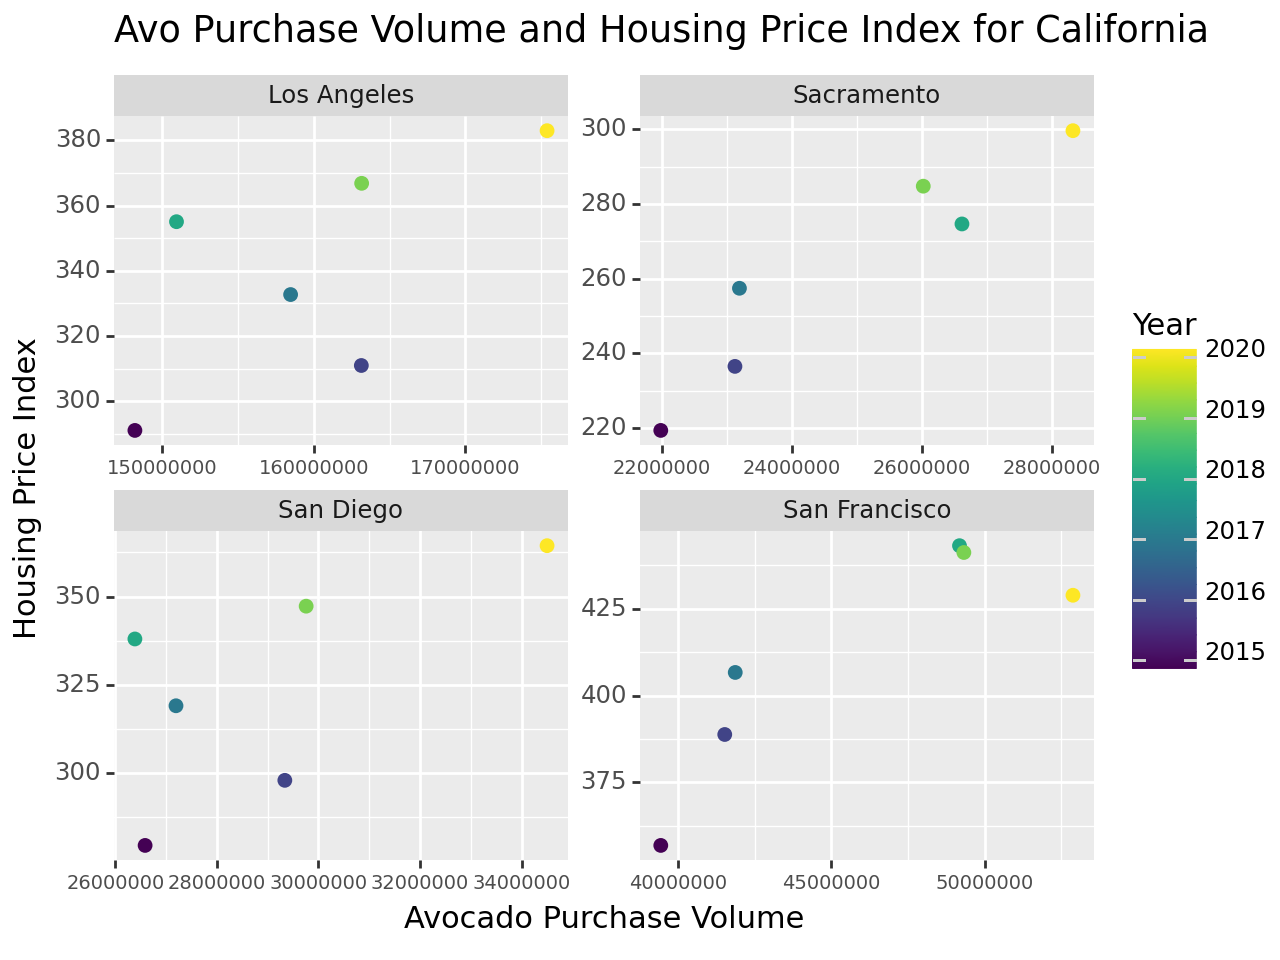

In [56]:
#do the same as above but for total volume
avos = Cali.groupby(['geography','year']).agg(Vol=('total_volume', 'sum')).reset_index()
avos = avos.rename(columns = {'geography':'City','year':'Yr'})
AH = avos.merge(hdf, on=['City','Yr'], how='outer')

p = (ggplot(AH, aes(x='Vol', y='Index', color='Yr'))
     + geom_point(size=2)
     #+ geom_text(aes(label='Yr'), size=8, va='bottom')
     + facet_wrap('~ City', scales='free')
     + labs(title="Avo Purchase Volume and Housing Price Index for California",
            x="Avocado Purchase Volume",
            y="Housing Price Index",
            color="Year")
     + theme(axis_text_x=element_text(size=7))
     #+ scale_y_log10(limits=(200, 500))

)

print(p)

In all cities in California, as the HPI increased, the Avocado Purchase Volume per year increased. This shows that even though housing prices were getting higher, people were still buying more avocados as they became a more popular grocery store purchase.